In [54]:
import pandas as pd
import numpy as np
import os
import pickle
from tqdm import tqdm
import gc
import xgboost as xgb
import numpy as np
import re
import pandas as pd
from sklearn.model_selection import train_test_split

out_path = r'.'
df = pd.read_csv(r'data/bio/de.csv', header=None)
df.columns = ['sentence_id', 'intent', 'language', 'written', 'spoken','type', 'token', 'token_id', 'tag']
df.sentence_id = df.sentence_id.astype(int)
df.token_id.fillna(0, inplace=True)
df.token.fillna('<sos>', inplace=True)
df.token_id = df.token_id.astype(int)
df

,sentence_id,intent,language,written,spoken,type,token,token_id,tag
0,0,Pad,NaN,NaN,NaN,plain,<sos>,0,O
1,0,Pad,NaN,NaN,NaN,plain,<sos>,0,O
2,0,Pad,NaN,NaN,NaN,plain,<sos>,0,O
3,0,OpenArea,de,sammlung,sammlung,mycloudarea,sammlung,1,O
4,0,OpenArea,de,auf,auf,plain,auf,2,O
...,...,...,...,...,...,...,...,...,...
4802978,381043,WatchNextEpisode,de,folge,folge,plain,folge,3,O
4802979,381043,WatchNextEpisode,de,bitte,bitte,plain,bitte,4,O
4802980,381043,Pad,NaN,NaN,NaN,plain,<sos>,0,O
4802981,381043,Pad,NaN,NaN,NaN,plain,<sos>,0,O


In [40]:
import pandas as pd
t = pd.read_csv('../output/test2.csv')
t.iloc[:50]

,sentence_id,language,intent,written,spoken,type,token_id,token,tag
0,0,en,Pad,<sos>,<sos>,Pad,-1,<sos>,O
1,0,en,OpenArea,show,show,plain,0,show,O
2,0,en,OpenArea,favourite pictures,favourite pictures,mycloudarea,1,favourite,O
3,0,en,OpenArea,favourite pictures,favourite pictures,mycloudarea,1,pictures,O
4,0,en,OpenArea,on,on,plain,2,on,O
5,0,en,OpenArea,mycloud,mycloud,plain,3,mycloud,O
6,0,en,Pad,<eos>,<eos>,Pad,-1,<eos>,O
7,1,en,Pad,<sos>,<sos>,Pad,-1,<sos>,O
8,1,en,OpenArea,show,show,plain,0,show,O
9,1,en,OpenArea,library,library,mycloudarea,1,library,O


In [55]:
import random
test_ratio = 0.1
random.seed(10)
max_id = max(df.sentence_id)
sentence_id = list(range(max_id))
random.shuffle(sentence_id)
t = int(test_ratio * max_id)
test_id = sentence_id[:t]
train_id = sentence_id[t:]

train = df[df['sentence_id'].isin(train_id)]
test = df[df['sentence_id'].isin(test_id)]
train.to_csv("train.csv", index=False)
test.to_csv("valid.csv", index=False)

In [56]:
def context_window_transform(data, pad_size, boundary_letter, max_num_features):
    pre = np.zeros(max_num_features)
    pre = [pre for x in np.arange(pad_size)]
    data = pre + data + pre
    neo_data = []
    for i in tqdm(np.arange(len(data) - pad_size * 2)):
        row = []
        for x in data[i : i + pad_size * 2 + 1]:
            row.append([boundary_letter])
            row.append(x)
        row.append([boundary_letter])
        neo_data.append([int(x) for y in row for x in y])
    return neo_data

def load_data(df, max_num_features=10, pad_size=1, boundary_letter=-1, space_letter=0, max_data_size=-1):
    x_data = []
    y_data =  pd.factorize(df['tag'])
    labels = y_data[1]
    y_data = y_data[0]
    gc.collect()
    for x in tqdm(df['token'].values):
        x_row = np.ones(max_num_features, dtype=int) * space_letter
        for xi, i in zip(list(str(x)), np.arange(max_num_features)):
            x_row[i] = ord(xi)
        x_data.append(x_row)

    x_data = x_data[:max_data_size]
    y_data = y_data[:max_data_size]
    x_data = np.array(context_window_transform(x_data, pad_size, boundary_letter, max_num_features))
    gc.collect()
    x_data = np.array(x_data)
    y_data = np.array(y_data)

    print('Total number of samples:', len(x_data))
    print('Use: ', max_data_size)
    print('x_data sample:')
    print(x_data[0])
    print('y_data sample:')
    print(y_data[0])
    print('labels:')
    print(labels)

    return x_data, y_data, labels

In [132]:
max_num_features = 10
pad_size = 3
boundary_letter = -1
space_letter = 0
max_data_size = -1

print("Train set:")
x_train, y_train, labels_train = load_data(train,
                                           max_num_features=max_num_features,
                                           pad_size=pad_size,
                                           boundary_letter=boundary_letter,
                                           space_letter=space_letter,
                                           max_data_size=max_data_size)
gc.collect()
print()

print("Valid set:")
x_valid, y_valid, labels_valid = load_data(test,
                                           max_num_features=max_num_features,
                                           pad_size=pad_size,
                                           boundary_letter=boundary_letter,
                                           space_letter=space_letter,
                                           max_data_size=max_data_size)
gc.collect()
print()


Train set:


100%|██████████| 4322469/4322469 [02:10<00:00, 33002.66it/s]


Total number of samples: 4322469
Use:  -1
x_data sample:
[ -1   0   0   0   0   0   0   0   0   0   0  -1   0   0   0   0   0   0
   0   0   0   0  -1   0   0   0   0   0   0   0   0   0   0  -1  60 115
 111 115  62   0   0   0   0   0  -1  60 115 111 115  62   0   0   0   0
   0  -1  60 115 111 115  62   0   0   0   0   0  -1 115  97 109 109 108
 117 110 103   0   0  -1]
y_data sample:
0
labels:
Index(['O', 'B-TBNorm', 'I-TBNorm'], dtype='object')

Valid set:


100%|██████████| 480502/480502 [00:13<00:00, 34542.18it/s]


Total number of samples: 480502
Use:  -1
x_data sample:
[ -1   0   0   0   0   0   0   0   0   0   0  -1   0   0   0   0   0   0
   0   0   0   0  -1   0   0   0   0   0   0   0   0   0   0  -1  60 115
 111 115  62   0   0   0   0   0  -1  60 115 111 115  62   0   0   0   0
   0  -1  60 115 111 115  62   0   0   0   0   0  -1  98 105 108 100 101
 114   0   0   0   0  -1]
y_data sample:
0
labels:
Index(['O', 'B-TBNorm', 'I-TBNorm'], dtype='object')



In [139]:
labels = labels_train
num_class = len(labels)
x_valid, y_valid, labels_valid = load_data(test,
                                           max_num_features=max_num_features,
                                           pad_size=pad_size,
                                           boundary_letter=boundary_letter,
                                           space_letter=space_letter,
                                           max_data_size=max_data_size)
gc.collect()


dtrain = xgb.DMatrix(x_train, label=y_train)
dvalid = xgb.DMatrix(x_valid, label=y_valid)
watchlist = [(dvalid, 'valid'), (dtrain, 'train')]

param = {'objective':'multi:softmax',
         'eta':'0.3', 'max_depth':8,
         'silent':1, 'nthread':-1,
         'num_class':num_class,
         'eval_metric':'merror',
        'gpu_id':0, 'tree_method':'gpu_hist'}
model = xgb.train(param, dtrain, 1000, watchlist, early_stopping_rounds=20, verbose_eval=10)
# model = xgb.Booster({'nthread': -1})  # init model
# model.load_model(os.path.join(out_path, 'xgb_model'))
gc.collect()

pred = model.predict(dvalid)
pred = [labels[int(x)] for x in pred]
y_valid = [labels[x] for x in y_valid]
x_valid = [ [ chr(x) for x in y[2 + max_num_features: 2 + max_num_features * 2]] for y in x_valid]
x_valid = [''.join(x) for x in x_valid]
x_valid = [re.sub('a+$', '', x) for x in x_valid]

gc.collect()

df_pred = pd.DataFrame(columns=['data', 'predict', 'target'])
df_pred['data'] = x_valid
df_pred['predict'] = pred
df_pred['target'] = y_valid
df_pred.to_csv(os.path.join(out_path, 'ner/pred.csv'))

df_erros = df_pred.loc[df_pred['predict'] != df_pred['target']]
df_erros.to_csv(os.path.join(out_path, 'ner/errors.csv'), index=False)
model.save_model(os.path.join(out_path, 'ner/xgb_model'))

100%|██████████| 480502/480502 [00:13<00:00, 34883.80it/s]


Total number of samples: 480502
Use:  -1
x_data sample:
[ -1   0   0   0   0   0   0   0   0   0   0  -1   0   0   0   0   0   0
   0   0   0   0  -1   0   0   0   0   0   0   0   0   0   0  -1  60 115
 111 115  62   0   0   0   0   0  -1  60 115 111 115  62   0   0   0   0
   0  -1  60 115 111 115  62   0   0   0   0   0  -1  98 105 108 100 101
 114   0   0   0   0  -1]
y_data sample:
0
labels:
Index(['O', 'B-TBNorm', 'I-TBNorm'], dtype='object')
[00:54:02] WARNING: ../src/learner.cc:541: 
Parameters: { silent } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[0]	valid-merror:0.02265	train-merror:0.02256
[10]	valid-merror:0.01106	train-merror:0.01123
[20]	valid-merror:0.00558	train-merror:0.00567
[30]	valid-merror:0.00372	train-merror:0.00377
[40]	valid-merror:0.00274	train-mer

In [142]:
tag_before = 'O'
token_buffer = []
id_before = -1

k = test.copy()
k = k.reset_index(drop=True).iloc[:-1]
k = k[['sentence_id', 'token', 'tag']]
k.sentence_id = k.sentence_id.astype(str)
with open('ner/pred_id.csv', 'w') as outfile:
    for i, row in tqdm(k.iterrows()):
        item = {}
        if row['tag'] == 'O':
            if token_buffer:
                # output buffer
                item['sentence_id'] = id_before
                item['token'] = ' '.join(token_buffer)
                item['tag'] = 'B'
                token_buffer = []
                outfile.write(','.join(item.values()) + '\n')

            # output self
            item['sentence_id'] = row['sentence_id']
            item['token'] = row['token']
            item['tag'] = 'O'
            tag_before = 'O'
            id_before = row['sentence_id']
            outfile.write(','.join(item.values()) + '\n')
        else:
            token_buffer.append(row['token'])
            id_before = row['sentence_id']

480502it [00:53, 9015.87it/s]


In [140]:
from sklearn.metrics import classification_report as report
print(report(df_pred.predict, df_pred.target))


              precision    recall  f1-score   support

    B-TBNorm       1.00      1.00      1.00     21850
    I-TBNorm       1.00      1.00      1.00     26514
           O       1.00      1.00      1.00    432138

    accuracy                           1.00    480502
   macro avg       1.00      1.00      1.00    480502
weighted avg       1.00      1.00      1.00    480502



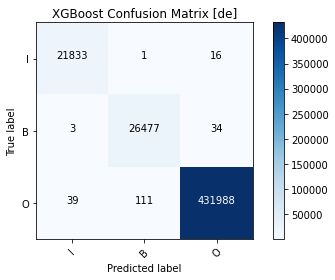

In [141]:
from sklearn.metrics import confusion_matrix as cm
from classification_report import  plot_confusion_matrix
matrix = cm(df_pred.predict, df_pred.target)
plot_confusion_matrix(matrix, classes=['I', 'B', 'O'],
                      title='XGBoost Confusion Matrix [{}]'.format('de'))


# ONMT

In [119]:
# use Opennmt
from helper import replace_space, make_src_tgt
from pathlib import Path
def prepare_onmt(df, name):
    data = df[df.tag != 'O']
    data = data[['sentence_id', 'token_id', 'language', 'written', 'spoken']]
    data = data.drop_duplicates().astype(str)
    data['tgt_char'] = data.written.apply(replace_space)
    data['src_char'] = data.spoken.apply(replace_space)
    make_src_tgt(data, name, data_output_dir=Path('./ner/data'), encoder_level='char', decoder_level='char')

prepare_onmt(train, 'train')
prepare_onmt(test, 'valid')

569it [00:00, 5689.27it/s]

Making src tgt for:  train


196828it [00:20, 9522.99it/s]
958it [00:00, 9573.46it/s]

Making src tgt for:  valid


21875it [00:02, 9532.95it/s]


In [124]:
from helper import replace_path_in_yaml
onmt_path = '../OpenNMT-py'
new_yaml_path = './ner/ner.yaml'
model = Path('ner') / '_step_{steps}.pt'.format(steps=10000)
output_path = 'ner/data/src_valid_pred.txt'

replace_path_in_yaml(yaml_path='./config/models/ner.yaml', new_yaml_path=new_yaml_path, model_path='./ner')
command_build_vocab = "python {onmt_path}/build_vocab.py -config  {yaml_path} -n_sample -1".format(
        onmt_path=onmt_path, yaml_path=new_yaml_path)
command_train = "python {onmt_path}/train.py -config {yaml_path}".format(onmt_path=onmt_path, yaml_path=new_yaml_path)

command_pred = "python {onmt_path}/translate.py -model {model} -src ner/data/src_valid.txt -output {output_path} " \
               "-beam_size {beam_size} -report_time".format(onmt_path=onmt_path, model=model,
                                                            output_path=output_path, beam_size=5)

In [121]:
command_build_vocab

'python ../OpenNMT-py/build_vocab.py -config  ./ner/ner.yaml -n_sample -1'

In [122]:
command_train

'python ../OpenNMT-py/train.py -config ./ner/ner.yaml'

In [123]:
command_pred

'python ../OpenNMT-py/translate.py -model ner/_step_10000.pt -src ner/data/src_valid.txt -output ner/data/src_valid_pred.txt -beam_size 5 -report_time'

In [127]:
from helper import recover_space
data = pd.read_csv(output_path, sep="\n", header=None, skip_blank_lines=False)
data = data.fillna('')
data.columns = ["prediction_char"]
data['prediction_token'] = data["prediction_char"].apply(recover_space)
data['src']= pd.read_csv('ner/data/src_valid.txt', sep="\n", header=None, skip_blank_lines=False)[0].apply(recover_space)
data['tgt'] = pd.read_csv('ner/data/tgt_valid.txt', sep="\n", header=None, skip_blank_lines=False)[0].apply(recover_space)
data

,prediction_char,prediction_token,src,tgt
0,r a d i o _ d r s _ 3,radio drs 3,radio drs drei,radio drs 3
1,r a d i o _ s r f _ 1,radio srf 1,radio srf eins,radio srf 1
2,r a d i o _ 3 2 _ g o l d i e s,radio 32 goldies,radio zweiunddreissig goldies,radio 32 goldies
3,r a d i o _ f m 1,radio fm1,radio fm eins,radio fm 1
4,s r f _ 1 _ f r e i b u r g,srf 1 freiburg,srf eins freiburg,srf 1 freiburg
...,...,...,...,...
21870,a m _ 9 . 1 1,am 9.11,am neunte november,am 9.11
21871,a m _ 1 4 . 1 2,am 14.12,am vierzehnte dezember,am 14.12
21872,a m _ 1 5 . 1 2,am 15.12,am fünfzehnte dezember,am 15.12
21873,a m _ 1 8 . 1 2,am 18.12,am achtzehnte dezember,am 18.12


In [128]:
# Evaluate Normalization
t = test.copy()
t = t[['sentence_id', 'token_id', 'language', 'written', 'spoken', 'tag']]
t.loc[t.tag!='O', 'tag'] = 'B'
t = t.drop_duplicates()
t = t[t.token_id != 0]
id_tobenormalized = t.index[t['tag']=='B'].tolist()
id_remainself = t.index[t['tag']=='O'].tolist()
print('Tokens to be normalized : {}'.format(len(id_tobenormalized)))
print('Tokens to remain self : {}'.format(len(id_remainself)))
t['after'] = ''
t.loc[id_tobenormalized, 'after'] = data['prediction_token'].tolist()
t.loc[id_remainself, 'after'] = t.loc[id_remainself, 'spoken']
t['after'] = t['after'].astype(str)
t['written'] = t['written'].astype(str)
t['spoken'] = t['spoken'].astype(str)
t = t.groupby(['sentence_id'], as_index = False).agg({'spoken': ' '.join, 'written': ' '.join, 'after': ' '.join})
t

Tokens to be normalized : 21875
Tokens to remain self : 185270


,sentence_id,spoken,written,after
0,25,bilder auf mycloud anzeigen,bilder auf mycloud anzeigen,bilder auf mycloud anzeigen
1,34,videos auf mycloud anzeigen,videos auf mycloud anzeigen,videos auf mycloud anzeigen
2,47,aktuelle auf mycloud anzeigen,aktuelle auf mycloud anzeigen,aktuelle auf mycloud anzeigen
3,78,bilder bei mycloud,bilder bei mycloud,bilder bei mycloud
4,79,aufnahmen bei mycloud,aufnahmen bei mycloud,aufnahmen bei mycloud
...,...,...,...,...
38099,381020,klicken,klicken,klicken
38100,381026,nächste folge bitte,nächste folge bitte,nächste folge bitte
38101,381027,nächste episode,nächste episode,nächste episode
38102,381037,wiedergabe der nächsten folge starten,wiedergabe der nächsten folge starten,wiedergabe der nächsten folge starten


In [143]:
classified_data = pd.read_csv('ner/pred_id.csv', header=None)
classified_data.columns = ['sentence_id', 'written', 'tag']
classified_data = classified_data[classified_data['written'] != '<sos>']
classified_data['src_char'] = classified_data.written.apply(replace_space)
classified_data['tgt_char'] = classified_data['src_char']
make_src_tgt(classified_data[classified_data.tag != 'O'], 'test', data_output_dir=Path('./ner/data'), encoder_level='char', decoder_level='char')
classified_data

1033it [00:00, 10322.80it/s]

Making src tgt for:  test


21874it [00:02, 10128.39it/s]


,sentence_id,written,tag,src_char,tgt_char
3,25,bilder,O,b i l d e r,b i l d e r
4,25,auf,O,a u f,a u f
5,25,mycloud,O,m y c l o u d,m y c l o u d
6,25,anzeigen,O,a n z e i g e n,a n z e i g e n
13,34,videos,O,v i d e o s,v i d e o s
...,...,...,...,...,...
453900,381037,starten,O,s t a r t e n,s t a r t e n
453907,381041,noch,O,n o c h,n o c h
453908,381041,eine,O,e i n e,e i n e
453909,381041,episode,O,e p i s o d e,e p i s o d e


In [144]:
command_pred = "python {onmt_path}/translate.py -model {model} -src ner/data/src_test.txt -output {output_path} " \
               "-beam_size {beam_size} -report_time".format(onmt_path=onmt_path, model=model,
                                                            output_path=output_path, beam_size=5)
command_pred

'python ../OpenNMT-py/translate.py -model <xgboost.core.Booster object at 0x7f813c989eb8> -src ner/data/src_test.txt -output ner/data/src_valid_pred.txt -beam_size 5 -report_time'

In [145]:
test_pred = pd.read_csv('ner/data/src_test_pred.txt', sep="\n", header=None, skip_blank_lines=False)
test_pred = test_pred.fillna('')
test_pred.columns = ["prediction_char"]
test_pred['prediction_token'] = test_pred["prediction_char"].apply(recover_space)
test_pred['src']= pd.read_csv('ner/data/src_test.txt', sep="\n", header=None, skip_blank_lines=False)[0].apply(recover_space)
test_pred

,prediction_char,prediction_token,src
0,r a d i o _ d r s _ 3,radio drs 3,radio drs drei
1,r a d i o _ s r f _ 1,radio srf 1,radio srf eins
2,r a d i o _ 3 2 _ g o l d i e s,radio 32 goldies,radio zweiunddreissig goldies
3,r a d i o _ f m 1,radio fm1,radio fm eins
4,s r f _ 1 _ f r e i b u r g,srf 1 freiburg,srf eins freiburg
...,...,...,...
21869,a m _ 9 . 1 1,am 9.11,am neunte november
21870,a m _ 1 4 . 1 2,am 14.12,am vierzehnte dezember
21871,a m _ 1 5 . 1 2,am 15.12,am fünfzehnte dezember
21872,a m _ 1 8 . 1 2,am 18.12,am achtzehnte dezember


In [146]:
# Evaluate Normalization
id_tobenormalized = classified_data.index[classified_data['tag']=='B'].tolist()
id_remainself = classified_data.index[classified_data['tag']=='O'].tolist()
print('Tokens to be normalized : {}'.format(len(id_tobenormalized)))
print('Tokens to remain self : {}'.format(len(id_remainself)))
classified_data['after'] = ''
classified_data.loc[id_tobenormalized, 'after'] = test_pred['prediction_token'].tolist()
classified_data.loc[id_remainself, 'after'] = classified_data.loc[id_remainself, 'written']
classified_res = classified_data.groupby(['sentence_id'], as_index = False).agg({'written': ' '.join, 'after': ' '.join})
t['classified_after'] = classified_res['after']
t

Tokens to be normalized : 21874
Tokens to remain self : 203410


,sentence_id,spoken,written,after,classified_after
0,25,bilder auf mycloud anzeigen,bilder auf mycloud anzeigen,bilder auf mycloud anzeigen,bilder auf mycloud anzeigen
1,34,videos auf mycloud anzeigen,videos auf mycloud anzeigen,videos auf mycloud anzeigen,videos auf mycloud anzeigen
2,47,aktuelle auf mycloud anzeigen,aktuelle auf mycloud anzeigen,aktuelle auf mycloud anzeigen,aktuelle auf mycloud anzeigen
3,78,bilder bei mycloud,bilder bei mycloud,bilder bei mycloud,bilder bei mycloud
4,79,aufnahmen bei mycloud,aufnahmen bei mycloud,aufnahmen bei mycloud,aufnahmen bei mycloud
...,...,...,...,...,...
38099,381020,klicken,klicken,klicken,klicken
38100,381026,nächste folge bitte,nächste folge bitte,nächste folge bitte,nächste folge bitte
38101,381027,nächste episode,nächste episode,nächste episode,nächste episode
38102,381037,wiedergabe der nächsten folge starten,wiedergabe der nächsten folge starten,wiedergabe der nächsten folge starten,wiedergabe der nächsten folge starten


In [147]:
t[t['written'] != t['classified_after']]

,sentence_id,spoken,written,after,classified_after
152,1645,auf radio radio fm eins schalten,auf radio radio fm 1 schalten,auf radio radio fm1 schalten,auf radio radio fm1 schalten
164,1803,auf radio bern eins love und relax schalten,auf radio bern1 love&relax schalten,auf radio bern 1 love&relax schalten,auf radio bern 1 love&relax schalten
165,1810,auf radio swr vier rheinland pfalz schalten,auf radio swr4 rheinland pfalz schalten,auf radio swr 4 rheinland pfalz schalten,auf radio swr 4 rheinland pfalz schalten
172,1884,auf radio fm eins in the mix schalten,auf radio fm1 in the mix schalten,auf radio fm 1 in the mix schalten,auf radio fm 1 in the mix schalten
174,1886,auf radio my einhundertfünf chill schalten,auf radio my105 chill schalten,auf radio my 105 chill schalten,auf radio my 105 chill schalten
...,...,...,...,...,...
38016,380052,wie ist die wettervorschau für null uhr sieben...,wie ist die wettervorschau für 00:37,wie ist die wettervorschau für 00:37,wie ist die wettervorschau für äsosx uhr 37
38017,380054,wie ist die wettervorschau für null uhr neunun...,wie ist die wettervorschau für 00:39,wie ist die wettervorschau für 00:39,wie ist die wettervorschau für äsosx uhr 39
38018,380058,wie ist die wettervorschau für null uhr dreiun...,wie ist die wettervorschau für 00:43,wie ist die wettervorschau für 00:43,wie ist die wettervorschau für äsosp uhr 43
38019,380071,wie ist die wettervorschau für null uhr sechsu...,wie ist die wettervorschau für 00:56,wie ist die wettervorschau für 00:56,wie ist die wettervorschau für äsosx uhr 56


In [130]:
t[t['written'] != t['after']]

,sentence_id,spoken,written,after
152,1645,auf radio radio fm eins schalten,auf radio radio fm 1 schalten,auf radio radio fm1 schalten
164,1803,auf radio bern eins love und relax schalten,auf radio bern1 love&relax schalten,auf radio bern 1 love&relax schalten
165,1810,auf radio swr vier rheinland pfalz schalten,auf radio swr4 rheinland pfalz schalten,auf radio swr 4 rheinland pfalz schalten
172,1884,auf radio fm eins in the mix schalten,auf radio fm1 in the mix schalten,auf radio fm 1 in the mix schalten
174,1886,auf radio my einhundertfünf chill schalten,auf radio my105 chill schalten,auf radio my 105 chill schalten
...,...,...,...,...
23741,237986,gerät wohnzimmer zwei in der schlafzimmer auss...,gerät wohnzimmer2 in der schlafzimmer ausschalten,gerät wohnzimmer 2 in der schlafzimmer ausscha...
23774,238337,gerät wohnzimmer zwei in der schreibzimmer aus...,gerät wohnzimmer2 in der schreibzimmer ausscha...,gerät wohnzimmer 2 in der schreibzimmer aussch...
23930,239940,bitte stell das gerät wohnzimmer zwei auf dem ...,bitte stell das gerät wohnzimmer2 auf dem schl...,bitte stell das gerät wohnzimmer 2 auf dem sch...
24029,241045,stelle gerät wohnzimmer zwei im fernsehzimmer aus,stelle gerät wohnzimmer2 im fernsehzimmer aus,stelle gerät wohnzimmer 2 im fernsehzimmer aus


# Train on LSTM base

In [91]:
t = test.copy()
t = t[['sentence_id', 'token_id', 'language', 'written', 'spoken', 'tag']]
t.loc[t.tag!='O', 'tag'] = 'B'
t = t.drop_duplicates()
t = t[t.token_id != 0]
t['written'] = t['written'].astype(str)
t['spoken'] = t['spoken'].astype(str)
t = t.groupby(['sentence_id'], as_index = False).agg({'spoken': ' '.join, 'written': ' '.join})
t



,sentence_id,spoken,written
0,25,bilder auf mycloud anzeigen,bilder auf mycloud anzeigen
1,34,videos auf mycloud anzeigen,videos auf mycloud anzeigen
2,47,aktuelle auf mycloud anzeigen,aktuelle auf mycloud anzeigen
3,78,bilder bei mycloud,bilder bei mycloud
4,79,aufnahmen bei mycloud,aufnahmen bei mycloud
...,...,...,...
38099,381020,klicken,klicken
38100,381026,nächste folge bitte,nächste folge bitte
38101,381027,nächste episode,nächste episode
38102,381037,wiedergabe der nächsten folge starten,wiedergabe der nächsten folge starten


In [92]:
def prepare_onmt_base(df, name, data_output_dir):
    df = df[['sentence_id', 'token_id', 'language', 'written', 'spoken', 'tag']]
    df.loc[df.tag!='O', 'tag'] = 'B'
    df = df.drop_duplicates()
    df = df[df.token_id != 0]
    df['written'] = df['written'].astype(str)
    df['spoken'] = df['spoken'].astype(str)
    df = df.groupby(['sentence_id'], as_index = False).agg({'spoken': ' '.join, 'written': ' '.join})
    
    df['tgt_char'] = df.written.apply(replace_space)
    df['src_char'] = df.spoken.apply(replace_space)
    make_src_tgt(df, name, data_output_dir=data_output_dir, encoder_level='char', decoder_level='char')

prepare_onmt_base(train, 'train', Path('./base/data'))
prepare_onmt_base(test, 'valid', Path('./base/data'))


/home/jovyan/.local/lib/python3.6/site-packages/pandas/core/indexing.py:1763: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  isetter(loc, value)
0it [00:00, ?it/s]

Making src tgt for:  train


342939it [00:41, 8219.56it/s] 
/home/jovyan/.local/lib/python3.6/site-packages/pandas/core/indexing.py:1763: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  isetter(loc, value)
878it [00:00, 8772.69it/s]

Making src tgt for:  valid


38104it [00:03, 9833.39it/s] 


In [108]:
from helper import replace_path_in_yaml
onmt_path = '../OpenNMT-py'
new_yaml_path = './base/base.yaml'
model = Path('base') / '_step_{steps}.pt'.format(steps=20000)
output_path = 'base/data/src_valid_pred.txt'

replace_path_in_yaml(yaml_path='./config/models/base.yaml', new_yaml_path=new_yaml_path, model_path='./base')
command_build_vocab = "python {onmt_path}/build_vocab.py -config  {yaml_path} -n_sample -1".format(
        onmt_path=onmt_path, yaml_path=new_yaml_path)
command_train = "python {onmt_path}/train.py -config {yaml_path}".format(onmt_path=onmt_path, yaml_path=new_yaml_path)

command_pred = "python {onmt_path}/translate.py -model {model} -src base/data/src_valid.txt -output {output_path} " \
               "-beam_size {beam_size} -report_time".format(onmt_path=onmt_path, model=model,
                                                            output_path=output_path, beam_size=5)

In [109]:
command_build_vocab

'python ../OpenNMT-py/build_vocab.py -config  ./base/base.yaml -n_sample -1'

In [98]:
command_train

'python ../OpenNMT-py/train.py -config ./base/base.yaml'

In [99]:
command_pred

'python ../OpenNMT-py/translate.py -model base/_step_20000.pt -src base/data/src_valid.txt -output base/data/src_valid_pred.txt -beam_size 5 -report_time'

In [116]:
test_pred_base = pd.read_csv('base/data/src_valid_pred.txt', sep="\n", header=None, skip_blank_lines=False)
test_pred_base = test_pred_base.fillna('')
test_pred_base.columns = ["prediction_char"]
test_pred_base['prediction_token'] = test_pred_base["prediction_char"].apply(recover_space)
test_pred_base['src']= pd.read_csv('base/data/src_valid.txt', sep="\n", header=None, skip_blank_lines=False)[0].apply(recover_space)
test_pred_base

,prediction_char,prediction_token,src
0,b i l d e r _ a u f _ m y c l o u d _ a n z e ...,bilder auf mycloud anzeigen,bilder auf mycloud anzeigen
1,v i d e o s _ a u f _ m y c l o u d _ a n z e ...,videos auf mycloud anzeigen,videos auf mycloud anzeigen
2,a k t u e l l e _ a u f _ m y c l o u d _ a n ...,aktuelle auf mycloud anzeigen,aktuelle auf mycloud anzeigen
3,b i l d e r _ b e i _ m y c l o u d,bilder bei mycloud,bilder bei mycloud
4,a u f n a h m e n _ b e i _ m y c l o u d,aufnahmen bei mycloud,aufnahmen bei mycloud
...,...,...,...
38099,k l i c k e n,klicken,klicken
38100,n ä c h s t e _ f o l g e _ b i t t e,nächste folge bitte,nächste folge bitte
38101,n ä c h s t e _ e p i s o d e,nächste episode,nächste episode
38102,w i e d e r g a b e _ d e r _ n ä c h s t e n ...,wiedergabe der nächsten folge starten,wiedergabe der nächsten folge starten


In [117]:
t['after_base'] = test_pred_base['prediction_token']
t

,sentence_id,spoken,written,after,after_base
0,25,bilder auf mycloud anzeigen,bilder auf mycloud anzeigen,bilder auf mycloud anzeigen,bilder auf mycloud anzeigen
1,34,videos auf mycloud anzeigen,videos auf mycloud anzeigen,videos auf mycloud anzeigen,videos auf mycloud anzeigen
2,47,aktuelle auf mycloud anzeigen,aktuelle auf mycloud anzeigen,aktuelle auf mycloud anzeigen,aktuelle auf mycloud anzeigen
3,78,bilder bei mycloud,bilder bei mycloud,bilder bei mycloud,bilder bei mycloud
4,79,aufnahmen bei mycloud,aufnahmen bei mycloud,aufnahmen bei mycloud,aufnahmen bei mycloud
...,...,...,...,...,...
38099,381020,klicken,klicken,klicken,klicken
38100,381026,nächste folge bitte,nächste folge bitte,nächste folge bitte,nächste folge bitte
38101,381027,nächste episode,nächste episode,nächste episode,nächste episode
38102,381037,wiedergabe der nächsten folge starten,wiedergabe der nächsten folge starten,wiedergabe der nächsten folge starten,wiedergabe der nächsten folge starten


In [118]:
t[t['written'] != t['after_base']]

,sentence_id,spoken,written,after,after_base
152,1645,auf radio radio fm eins schalten,auf radio radio fm 1 schalten,auf radio radio fm1 schalten,auf radio radio fm1 schalten
164,1803,auf radio bern eins love und relax schalten,auf radio bern1 love&relax schalten,auf radio bern1 love&relax schalten,auf radio bern 1 love&relax schalten
171,1883,auf radio fm eins in the mix schalten,auf radio fm 1 in the mix schalten,auf radio fm1 in the mix schalten,auf radio fm1 in the mix schalten
174,1886,auf radio my einhundertfünf chill schalten,auf radio my105 chill schalten,auf radio my 105 chill schalten,auf radio my 105 chill schalten
184,1996,auf radio swr zwei schalten,auf radio swr2 schalten,auf radio swr 2 schalten,auf radio swr 2 schalten
...,...,...,...,...,...
23549,236354,stell das gerät wohnzimmer zwei im bad aus,stell das gerät wohnzimmer 2 im bad aus,stell das gerät wohnzimmer 2 im bad aus,stell das gerät wohnzimmer2 im bad aus
23794,238529,gerät wohnzimmer zwei in der terrasse ausschalten,gerät wohnzimmer 2 in der terrasse ausschalten,gerät wohnzimmer 2 in der terrasse ausschalten,gerät wohnzimmer2 in der terrasse ausschalten
23901,239647,bitte stell das gerät wohnzimmer zwei auf dem ...,bitte stell das gerät wohnzimmer 2 auf dem spe...,bitte stell das gerät wohnzimmer 2 auf dem spe...,bitte stell das gerät wohnzimmer2 auf dem spei...
23979,240509,bitte stell das gerät wohnzimmer zwei auf dem ...,bitte stell das gerät wohnzimmer 2 auf dem klo ab,bitte stell das gerät wohnzimmer 2 auf dem klo ab,bitte stell das gerät wohnzimmer2 auf dem klo ab
